In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import curvedsky as cs
import binning
from tqdm import tqdm

In [2]:
sys.path.append('../')

In [3]:
%load_ext autoreload
%autoreload 2
from lbxs4.cmb import CMBLensed
from lbxs4.simulations import LBSky,S4Sky
from lbxs4.filtering import FiltCoadd
from lbxs4.multitracer import CoaddKappa
from lbxs4.delensing import Delenser
from lbxs4.config import *

In [4]:
cmb = CMBLensed()

In [5]:

lb_sky = LBSky(512)
s4_sky = S4Sky()

In [39]:
mask = lb_sky.mask*hp.ud_grade(s4_sky.mask,512)

In [40]:
def inputEB(i):
    teb_input = cmb.TEB(i)
    TQU = hp.alm2map(teb_input,512)/2.726e6 * mask
    Ein,Bin = cs.utils.hp_map2alm_spin(512,1024,1024, 2, TQU[1], TQU[2])
    return Ein,Bin

In [41]:
Ein,Bin = inputEB(0)

In [8]:
dire = '/pscratch/sd/l/lonappan/LBxS4'

In [9]:
filt1 = FiltCoadd(dire,lblib=lb_sky,s4lib=s4_sky,coadd=True)
filt2 = FiltCoadd(dire,s4lib=s4_sky)
filt3 = FiltCoadd(dire,lblib=lb_sky)

INFO:LiteBIRD simulation library is loaded
INFO:CMB-S4 simulation library is loaded
INFO:Coaddition is enabled
INFO:CMB-S4 simulation library is loaded
INFO:LiteBIRD simulation library is loaded


In [10]:
lbE = []
s4E = []
lbs4E = []
for i in tqdm(range(10)):
    lbE.append(cs.utils.alm2cl(filt3.lmax,filt3.filtEmode(i,wiener=True)))
    s4E.append(cs.utils.alm2cl(filt2.lmax,filt2.filtEmode(i,wiener=True)))
    lbs4E.append(cs.utils.alm2cl(filt1.lmax,filt1.filtEmode(i,wiener=True)))

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


In [11]:
lbE = np.array(lbE)
s4E = np.array(s4E)
lbs4E = np.array(lbs4E)

0.5038633022296204

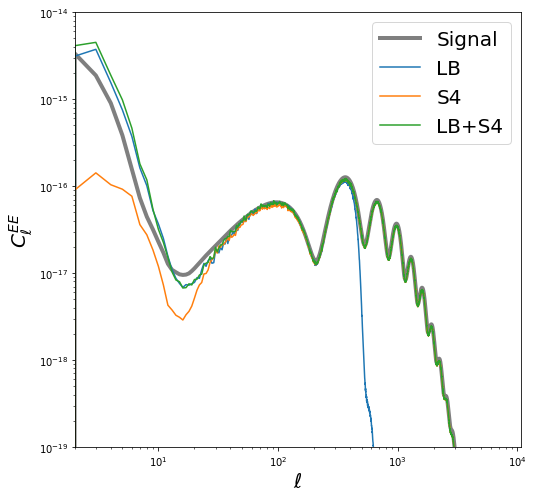

In [30]:
plt.figure(figsize=(8,8))
plt.loglog(filt1.cl_len[1,:],lw=4,alpha=.5,c='k',label='Signal')
plt.loglog(lbE.mean(axis=0)/filt3.fsky,label='LB')
plt.loglog(s4E.mean(axis=0)/filt2.fsky,label='S4')
plt.loglog(lbs4E.mean(axis=0)/filt1.fsky,label='LB+S4')
plt.legend(fontsize=20)
plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$C_{\ell}^{EE}$',fontsize=20)
plt.ylim(1e-19,1e-14)
plt.xlim(2,None)
plt.savefig('EE.pdf',dpi=300,bbox_inches='tight')

In [31]:
mask_karg = {'lb_mask':lb_sky.mask,'s4_mask':s4_sky.mask}
kappa  = CoaddKappa(dire,2,1024,512,**mask_karg)

../lbxs4/utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  cls[k][ell[idc]] = cols[i + 1][idc] / we[idc]
../lbxs4/multitracer.py:255: RuntimeWarning: divide by zero encountered in true_divide
  self.INls = np.array( [ 1./self.cov_n[:,:,l].diagonal() for l in range(lmax+1) ] ).T


In [34]:
delens1 = Delenser(dire,filt1,kappa,)
delens2 = Delenser(dire,filt2,kappa,)
delens3 = Delenser(dire,filt3,kappa,elmax=1024)

In [35]:
lensB1 = delens1.lensing_B(0)
lensB2 = delens2.lensing_B(0)
lensB3 = delens3.lensing_B(0)

In [47]:
cmask = lb_sky.mask*hp.ud_grade(s4_sky.mask,512)

In [62]:
cmask = cmask.astype('int')

In [63]:
tempB_my = cs.utils.hp_alm2map(512,1024,1024,lensB1)
inpB_my = cs.utils.hp_alm2map(512,1024,1024,Bin)
tempB_masked = hp.ma(tempB_my*cmask)
inpB_masked = hp.ma(inpB_my*cmask)
tempB_masked.mask = np.logical_not(cmask)
inpB_masked.mask = np.logical_not(cmask)
tempB_masked = tempB_masked.filled()
inpB_masked = inpB_masked.filled()

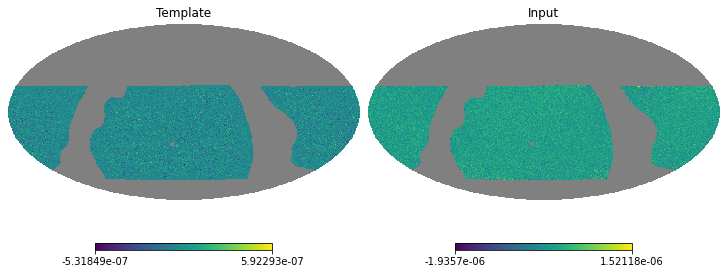

In [65]:
plt.figure(figsize=(10,12))
hp.mollview(tempB_masked,sub=(1,2,1),title='Template')
hp.mollview(inpB_masked,sub=(1,2,2),title='Input')
plt.savefig('Bmode.pdf',dpi=300,bbox_inches='tight')

In [20]:
def rho(lensB,Bin):
    b1 = cs.utils.alm2cl(1024,lensB)
    b2 = cs.utils.alm2cl(1024,Bin)
    b12 = cs.utils.alm2cl(1024,lensB,Bin)
    return b12/np.sqrt(b1*b2)

def rho_arr(delensobj,no=20):
    r = []
    for i in tqdm(range(no)):
        _,Bin = inputEB(i)
        lensB = delensobj.lensing_B(i)
        r.append(rho(lensB,Bin))
    return np.array(r)
    

In [21]:
rho_lb = rho_arr(delens3,20)

  0%|          | 0/20 [00:00<?, ?it/s]/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 20/20 [02:03<00:00,  6.19s/it]


In [22]:
rho_s4 = rho_arr(delens2,20)

  0%|          | 0/20 [00:00<?, ?it/s]/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 20/20 [04:15<00:00, 12.79s/it]


In [23]:
rho_lbs4 = rho_arr(delens1,20)

  0%|          | 0/20 [00:00<?, ?it/s]/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 20/20 [04:27<00:00, 13.37s/it]


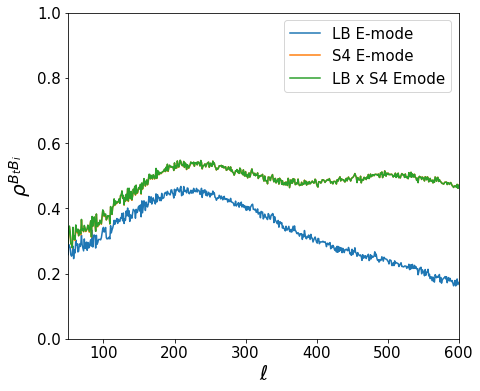

In [25]:
siglb = rho_lb.std(axis=0)
meanlb = rho_lb.mean(axis=0,)
sigs4 = rho_s4.std(axis=0)
means4 = rho_s4.mean(axis=0)
siglbs4 = rho_lbs4.std(axis=0)
meanlbs4 = rho_lbs4.mean(axis=0)
l = np.arange(len(rho_lb[0]))
plt.figure(figsize=(7,6))
plt.plot(l,meanlb,label='LB E-mode')
#plt.fill_between(l,meanlb-siglb,meanlb+siglb,alpha=0.3)
plt.plot(l,means4,label='S4 E-mode')
#plt.fill_between(l,means4-sigs4,means4+sigs4,alpha=0.3)
plt.plot(l,meanlbs4,label='LB x S4 Emode')
#plt.fill_between(l,meanlbs4-siglbs4,meanlbs4+siglbs4,alpha=0.3)
plt.xlim(50,600)
plt.ylim(0,1)
plt.legend(fontsize=15)
plt.xlabel('$\ell$',fontsize=20)
plt.ylabel('$\\rho^{B_tB_i}$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('rho.pdf',bbox_inches='tight',dpi=300)


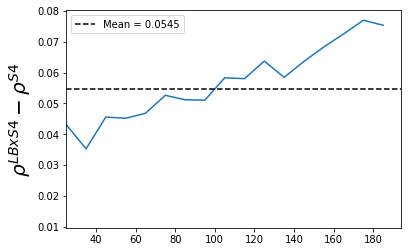

In [28]:
plt.plot(*binner((meanlbs4-meanlb)[2:200],10))
plt.ylabel('$\\rho^{LBxS4} - \\rho^{S4}$',fontsize=20)
plt.axhline(np.mean((meanlbs4-meanlb)[2:200]),label=f"Mean = {np.mean((meanlbs4-meanlb)[2:200]):.4f}",c='k',ls='--')
plt.xlim(25,None)
plt.legend()

In [51]:
np.mean((means4-meanlb)[2:200])

0.05183911724103389

In [27]:
def binner(C_l, bin_width=10):

    num_bins = len(C_l) // bin_width

    bin_center = np.zeros(num_bins)
    bin_cl = np.zeros(num_bins)

    for i in range(num_bins):
        start = i * bin_width
        end = start + bin_width


        bin_center[i] = (start + end) / 2

        bin_cl[i] = np.mean(C_l[start:end])

    return bin_center, bin_cl